In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from copy import deepcopy
import os

%matplotlib inline

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "imgs"
os.makedirs(IMG_DIR, exist_ok=True)

In [ ]:
def class_to_onehot(Y):
    Yoh = np.zeros((len(Y), max(Y) + 1))
    Yoh[range(len(Y)), Y] = 1
    return Yoh

def eval_perf_binary(Y, Y_):
    tp = sum(np.logical_and(Y == Y_, Y_ == True))
    fn = sum(np.logical_and(Y != Y_, Y_ == True))
    tn = sum(np.logical_and(Y == Y_, Y_ == False))
    fp = sum(np.logical_and(Y != Y_, Y_ == False))
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fn + tn + fp)
    return accuracy, recall, precision

def eval_perf_multi(Y, Y_):
    """
    Evaluate performance of multiclass classification

    Parameters
    ----------
        Y: predicted class indices, np.array of shape Nx1
        Y_: ground truth indices, np.array of shape Nx1

    Returns
    -------
        M: confusion_matrix
        accuracy, precision, recall: metrics

    """
    Y_ = Y_.reshape(-1)
    Y = Y.reshape(-1)
    num_classes = np.max(Y_) + 1
    M = np.zeros((num_classes, num_classes))

    # Slow
    for y_, y in zip(Y_, Y):
        M[y_][y] += 1

    accuracy = np.trace(M) / np.sum(M)
    # precision = np.diag(M) / np.sum(M, axis=0)
    # recall = np.diag(M) / np.sum(M, axis=1)
    precision = np.divide(np.diag(M), np.sum(M, axis=0), where=np.sum(M, axis=0) != 0)
    recall = np.divide(np.diag(M), np.sum(M, axis=1), where=np.sum(M, axis=1) != 0)

    return M.astype(np.int32), accuracy, recall, precision

def graph_surface(function, rect, offset=0.5, width=256, height=256):
    """Creates a surface plot (visualize with plt.show)

    Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
                ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

    Returns:
    None
    """

    lsw = np.linspace(rect[0][1], rect[1][1], width)
    lsh = np.linspace(rect[0][0], rect[1][0], height)
    xx0,xx1 = np.meshgrid(lsh, lsw)
    grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)

    #get the values and reshape them
    values=function(grid).reshape((width,height))

    # fix the range and offset
    delta = offset if offset else 0
    maxval=max(np.max(values)-delta, - (np.min(values)-delta))

    # draw the surface and the offset
    plt.pcolormesh(xx0, xx1, values,
        vmin=delta-maxval, vmax=delta+maxval, cmap="jet")

    if offset != None:
        plt.contour(xx0, xx1, values, colors='black', levels=[offset])

def graph_data(X,Y_, Y, special=[]):
    """Creates a scatter plot (visualize with plt.show)

    Arguments:
        X:       datapoints
        Y_:      groundtruth classification indices
        Y:       predicted class indices
        special: use this to emphasize some points

    Returns:
        None
    """
    # colors of the datapoint markers
    palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
    colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
    for i in range(len(palette)):
        colors[Y_==i] = palette[i]

    # sizes of the datapoint markers
    sizes = np.repeat(20, len(Y_))
    sizes[special] = 40

    # draw the correctly classified datapoints
    good = (Y_==Y)
    plt.scatter(X[good,0],X[good,1], c=colors[good],
                s=sizes[good], marker='o', edgecolors='black')

    # draw the incorrectly classified datapoints
    bad = (Y_!=Y)
    plt.scatter(X[bad,0],X[bad,1], c=colors[bad],
                s=sizes[bad], marker='s', edgecolors='black')


In [ ]:
class PTDeep(nn.Module):
    def __init__(self, layers, activation=nn.ReLU, device="cpu"):
        super().__init__()
        self.activation = activation()
        self.flat = nn.Flatten()
        self.layers = nn.Sequential()

        if device == "cuda" and torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        for i, (dim_in, dim_out) in enumerate(zip(layers, layers[1:])):
            self.layers.add_module(f"fc{i}", nn.Linear(dim_in, dim_out, device=self.device))
            if i != len(layers) - 1:
                self.layers.add_module(f"act{i}", activation())

        self.layers.add_module("softmax", nn.Softmax(dim=1))

    def forward(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X = self.flat(X)
        X = self.layers(X)
        return X

    def get_loss(self, X, Yoh_):
        probs = self.forward(X)
        loss = -torch.sum(Yoh_ * torch.log(probs + 1e-12)) / X.shape[0]
        return loss

    def count_params(self):
        total = 0
        for name, param in self.named_parameters():
            print(f"{name} ... {list(param.shape)}, numel={param.numel()}")
            total += param.numel()
        return total

    @torch.no_grad()
    def predict(self, X):
        probs = self.forward(X)
        preds = probs.argmax(axis=1)
        return preds

def evaluate(model, X, Y_):
    Y = model.predict(X)
    M, accuracy, recall, precision = eval_perf_multi(Y.cpu().numpy(), Y_.cpu().numpy())
    return M, accuracy, recall, precision

def visualize_weights(w, filename=None):
    w = w.reshape(C, 28, 28)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(10):
        axes[i].set_title(f"Weights for digit {i}")
        axes[i].imshow(w[i], cmap="gray")
        axes[i].axis("off")

    if filename is not None:
        plt.savefig(os.path.join(IMG_DIR, filename), dpi=300)

    plt.tight_layout()
    plt.show()

In [ ]:
def class_to_onehot(y):
    C = y.max() + 1
    yoh = torch.zeros(y.shape[0], C, device=y.device)
    yoh[range(y.shape[0]), y] = 1
    return yoh

def load_mnist(dirname="/tmp/mnist"):
    mnist_train = torchvision.datasets.MNIST(dirname, train=True, download=True)
    mnist_test = torchvision.datasets.MNIST(dirname, train=False, download=True)

    X_train, y_train = mnist_train.data, mnist_train.targets
    X_test, y_test = mnist_test.data, mnist_test.targets
    #X_train, X_test = X_train.float().div_(255.0), X_test.float().div_(255.0)
    X_train, X_test = X_train.float(), X_test.float()

    return X_train.to(DEVICE), y_train.to(DEVICE), X_test.to(DEVICE), y_test.to(DEVICE)

X_train, y_train, X_test, y_test = load_mnist()
N = X_train.shape[0]
D = X_train.shape[1] * X_train.shape[2]
C = y_train.max().add_(1).item()

yoh_train = class_to_onehot(y_train)
yoh_test = class_to_onehot(y_test)
h = 100
configs = [(D, C), (D, h, C), (D, h, h, C), (D, h, h, h, C)]

In [ ]:
def train_without_early_stop(config, X_train, yoh_train, X_test, yoh_test, num_epochs=1000, lr=1e-1, weight_decay=1e-3, show_freq=100):
    torch.manual_seed(100)
    model = PTDeep(config, device=X_train.device.type)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loss_hist = []
    test_loss_hist = []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(num_epochs):
        optimizer.zero_grad()
        loss = model.get_loss(X_train, yoh_train)
        loss.backward()
        optimizer.step()
        train_loss_hist.append(loss.item())
        if i % show_freq == 0:
            with torch.no_grad():
                test_loss = model.get_loss(X_test, yoh_test)
                test_loss_hist.append(test_loss.item())
                if best_loss > test_loss:
                    best_loss = test_loss
                    best_model = deepcopy(model)
                print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Test Loss: {test_loss:.2f}")

    return best_model, train_loss_hist, test_loss_hist

In [ ]:
def train_with_early_stop(config, X_train, yoh_train, X_test, yoh_test, num_epochs=1000, lr=1e-1, weight_decay=1e-3, show_freq=100, patience=3, tolerance=1e-3):
    torch.manual_seed(100)
    model = PTDeep(config, device=X_train.device.type)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loss_hist = []
    test_loss_hist = []
    best_model = deepcopy(model)
    best_loss = float("inf")
    curr_patience = 0

    for i in range(num_epochs):
        optimizer.zero_grad()
        loss = model.get_loss(X_train, yoh_train)
        loss.backward()
        optimizer.step()
        train_loss_hist.append(loss.item())
        if i % show_freq == 0:
            with torch.no_grad():
                test_loss = model.get_loss(X_test, yoh_test)
                test_loss_hist.append(test_loss.item())
                if best_loss - test_loss > tolerance:
                    best_loss = test_loss
                    best_model = deepcopy(model)
                    curr_patience = 0
                else:
                    curr_patience += 1
                print(f"Step: {i + 1}/{num_epochs}, Train Loss: {loss:.2f}, Test Loss: {test_loss:.2f}")
                if curr_patience >= patience:
                    print(f"Patience reached {curr_patience}")
                    print("Early stop")
                    break

    return best_model, train_loss_hist, test_loss_hist

## Procjena konfiguracija

In [ ]:
model1, train_loss_hist1, test_loss_hist1 = train_without_early_stop(configs[0], X_train, yoh_train, X_test, yoh_test, num_epochs=5000, lr=1e-2, weight_decay=1e-1)
M, accuracy, recall, precision = evaluate(model1, X_test, y_test)
print(f"Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Step: 0/5000, Train Loss: 2.32, Test Loss: 2.31
Step: 100/5000, Train Loss: 1.72, Test Loss: 1.70
Step: 200/5000, Train Loss: 1.36, Test Loss: 1.33
Step: 300/5000, Train Loss: 1.16, Test Loss: 1.13
Step: 400/5000, Train Loss: 1.05, Test Loss: 1.02
Step: 500/5000, Train Loss: 0.98, Test Loss: 0.95
Step: 600/5000, Train Loss: 0.93, Test Loss: 0.90
Step: 700/5000, Train Loss: 0.90, Test Loss: 0.87
Step: 800/5000, Train Loss: 0.87, Test Loss: 0.84
Step: 900/5000, Train Loss: 0.86, Test Loss: 0.82
Step: 1000/5000, Train Loss: 0.84, Test Loss: 0.81
Step: 1100/5000, Train Loss: 0.83, Test Loss: 0.80
Step: 1200/5000, Train Loss: 0.82, Test Loss: 0.79
Step: 1300/5000, Train Loss: 0.82, Test Loss: 0.79
Step: 1400/5000, Train Loss: 0.81, Test Loss: 0.78
Step: 1500/5000, Train Loss: 0.81, Test Loss: 0.78
Step: 1600/5000, Train Loss: 0.81, Test Loss: 0.77
Step: 1700/5000, Train Loss: 0.80, Test Loss: 0.77
Step: 1800/5000, Train Loss: 0.80, Test Loss: 0.77
Step: 1900/5000, Train Loss: 0.80, Test Los

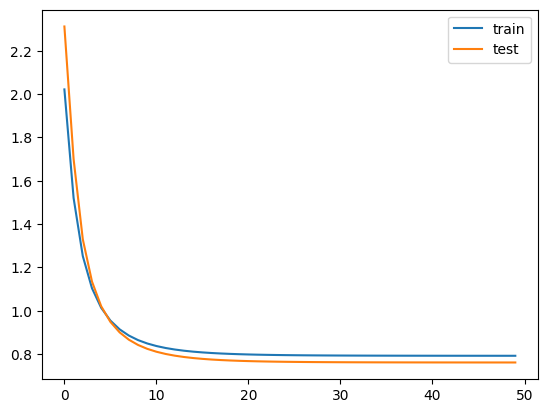

In [ ]:
plt.plot(np.array(train_loss_hist1).reshape(-1, 100).mean(axis=1).tolist(), label="train")
plt.plot(test_loss_hist1, label="test")
plt.legend()
plt.show()

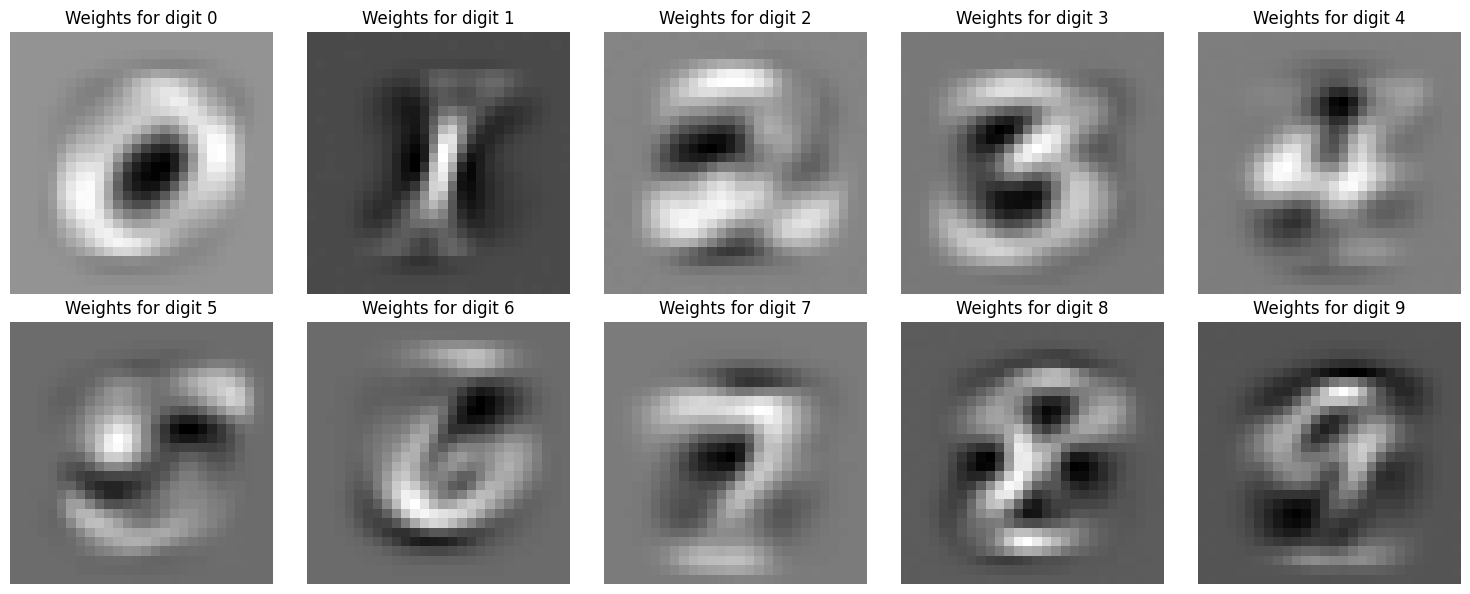

In [ ]:
visualize_weights(model1.layers[0].weight.data.cpu().numpy(), "weight_reg_1e-1.png")
#visualize_weights(model1.layers[0].weight.data.cpu().numpy())

In [ ]:
model2, train_loss_hist2, test_loss_hist2 = train_without_early_stop(configs[1], X_train, yoh_train, X_test, yoh_test, num_epochs=5000, lr=1e-2, weight_decay=1e-2)
M, accuracy, recall, precision = evaluate(model2, X_test, y_test)
print(f"Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Step: 0/5000, Train Loss: 2.31, Test Loss: 2.31
Step: 100/5000, Train Loss: 2.21, Test Loss: 2.20
Step: 200/5000, Train Loss: 2.04, Test Loss: 2.03
Step: 300/5000, Train Loss: 1.81, Test Loss: 1.80
Step: 400/5000, Train Loss: 1.55, Test Loss: 1.53
Step: 500/5000, Train Loss: 1.29, Test Loss: 1.26
Step: 600/5000, Train Loss: 1.08, Test Loss: 1.05
Step: 700/5000, Train Loss: 0.93, Test Loss: 0.90
Step: 800/5000, Train Loss: 0.82, Test Loss: 0.79
Step: 900/5000, Train Loss: 0.74, Test Loss: 0.71
Step: 1000/5000, Train Loss: 0.68, Test Loss: 0.65
Step: 1100/5000, Train Loss: 0.64, Test Loss: 0.61
Step: 1200/5000, Train Loss: 0.60, Test Loss: 0.57
Step: 1300/5000, Train Loss: 0.57, Test Loss: 0.55
Step: 1400/5000, Train Loss: 0.55, Test Loss: 0.52
Step: 1500/5000, Train Loss: 0.53, Test Loss: 0.50
Step: 1600/5000, Train Loss: 0.51, Test Loss: 0.49
Step: 1700/5000, Train Loss: 0.50, Test Loss: 0.47
Step: 1800/5000, Train Loss: 0.49, Test Loss: 0.46
Step: 1900/5000, Train Loss: 0.48, Test Los

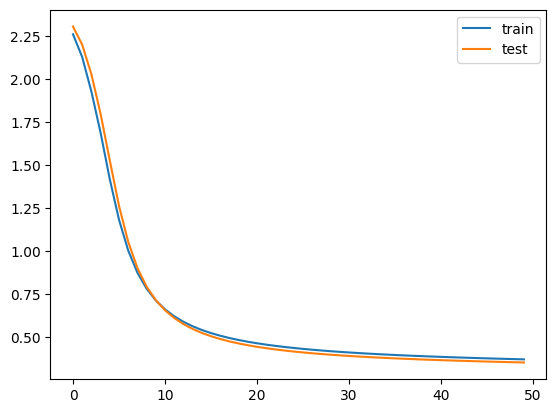

In [ ]:
plt.plot(np.array(train_loss_hist2).reshape(-1, 100).mean(axis=1).tolist(), label="train")
plt.plot(test_loss_hist2, label="test")
plt.legend()
plt.show()

In [ ]:
model3, train_loss_hist3, test_loss_hist3 = train_without_early_stop(configs[2], X_train, yoh_train, X_test, yoh_test, num_epochs=10000, lr=1e-3, weight_decay=1e-1)
M, accuracy, recall, precision = evaluate(model3, X_test, y_test)
print(f"Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Step: 0/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 100/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 200/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 300/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 400/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 500/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 600/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 700/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 800/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 900/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1000/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1100/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1200/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1300/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1400/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1500/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1600/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1700/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1800/10000, Train Loss: 2.30, Test Loss: 2.30
Step: 1900/10000, Train 

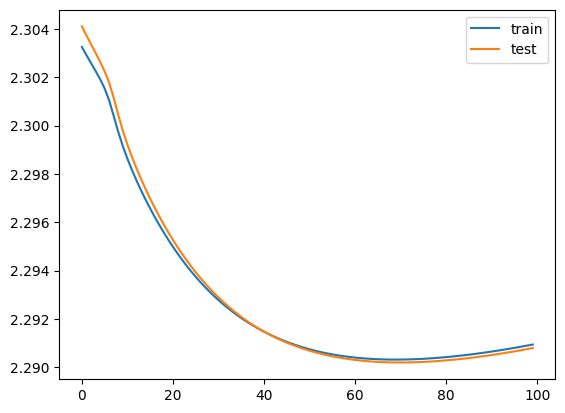

In [ ]:
plt.plot(np.array(train_loss_hist3).reshape(-1, 100).mean(axis=1).tolist(), label="train")
plt.plot(test_loss_hist3, label="test")
plt.legend()
plt.show()

In [ ]:
model1.count_params()

layers.fc0.weight ... [10, 784], numel=7840
layers.fc0.bias ... [10], numel=10


7850

In [ ]:
model2.count_params()

layers.fc0.weight ... [100, 784], numel=78400
layers.fc0.bias ... [100], numel=100
layers.fc1.weight ... [10, 100], numel=1000
layers.fc1.bias ... [10], numel=10


79510

In [ ]:
model3.count_params()

layers.fc0.weight ... [100, 784], numel=78400
layers.fc0.bias ... [100], numel=100
layers.fc1.weight ... [100, 100], numel=10000
layers.fc1.bias ... [100], numel=100
layers.fc2.weight ... [10, 100], numel=1000
layers.fc2.bias ... [10], numel=10


89610

In [ ]:
probs = model2.forward(X_test)
losses = torch.sum(-yoh_test * torch.log(probs + 1e-12), dim=1)
sorted_losses, sorted_indices = torch.sort(losses)

lowest_loss_indices = sorted_indices[:10]
lowest_loss_values = sorted_losses[:10]
highest_loss_indices = sorted_indices[-10:]
highest_loss_values = sorted_losses[-10:]

lowest_loss_samples = X_test[lowest_loss_indices]
highest_loss_samples = X_test[highest_loss_indices]
losses.mean().item()

0.3499942421913147

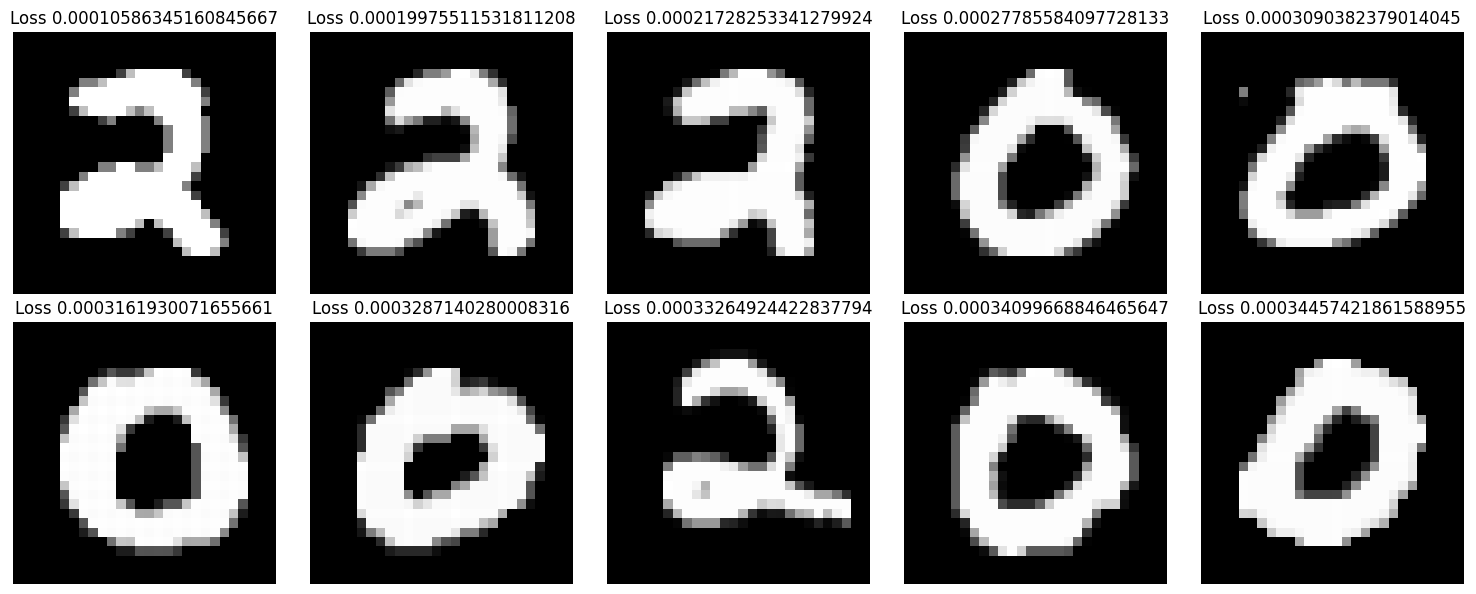

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    loss = lowest_loss_values[i].detach().cpu().item()
    sample = lowest_loss_samples[i].detach().cpu().numpy()
    axes[i].set_title(f"Loss {loss}")
    axes[i].imshow(sample, cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

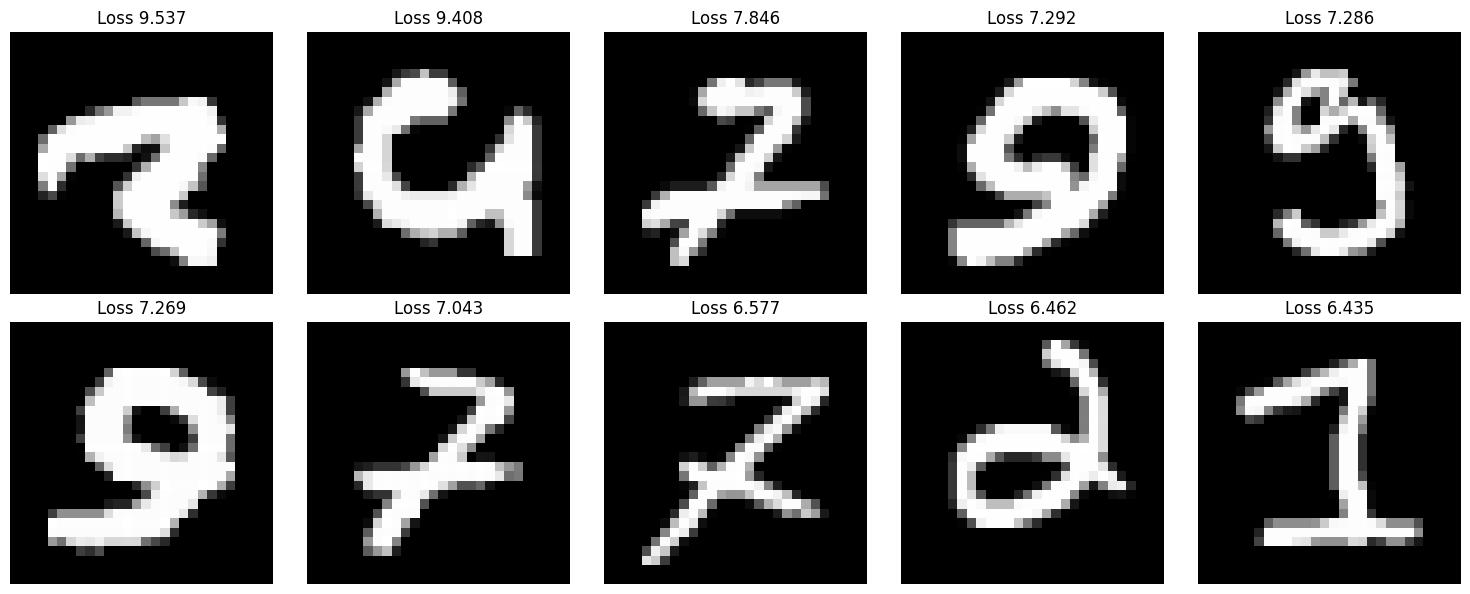

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    loss = highest_loss_values[i].detach().cpu().item()
    sample = highest_loss_samples[i].detach().cpu().numpy()
    axes[-i - 1].set_title(f"Loss {loss:.3f}")
    axes[-i - 1].imshow(sample, cmap="gray")
    axes[-i - 1].axis("off")

plt.tight_layout()
plt.show()

## Train-Val-Test split

In [ ]:
X_train, y_train, X_test, y_test = load_mnist()
N = X_train.shape[0]
D = X_train.shape[1] * X_train.shape[2]
C = y_train.max().add_(1).item()
h = 100
train_ratio = 0.8
configs = [(D, C), (D, h, C), (D, h, h, C), (D, h, h, h, C)]

train_size = int(X_train.shape[0] * train_ratio)
X_val, y_val = X_train[train_size:], y_train[train_size:]
X_train, y_train = X_train[:train_size], y_train[:train_size]

yoh_train = class_to_onehot(y_train)
yoh_val = class_to_onehot(y_val)
yoh_test = class_to_onehot(y_test)

In [ ]:
def train_without_early_stop(config, X_train, yoh_train, X_val, yoh_val, num_epochs=1000, lr=1e-1, weight_decay=1e-3, show_freq=100):
    torch.manual_seed(100)
    model = PTDeep(config, device=X_train.device.type)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loss_hist = []
    val_loss_hist = []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(num_epochs):
        optimizer.zero_grad()
        loss = model.get_loss(X_train, yoh_train)
        loss.backward()
        optimizer.step()
        train_loss_hist.append(loss.item())
        with torch.no_grad():
            val_loss = model.get_loss(X_val, yoh_val)
            val_loss_hist.append(val_loss.item())
        if i % show_freq == 0:
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = deepcopy(model)
            print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}")

    return best_model, train_loss_hist, val_loss_hist

In [ ]:
model, train_loss_hist, val_loss_hist = train_without_early_stop(configs[1], X_train, yoh_train, X_val, yoh_val, num_epochs=5000, lr=1e-2, weight_decay=1e-2)

Step: 0/5000, Train Loss: 2.31, Val Loss: 2.31
Step: 100/5000, Train Loss: 2.21, Val Loss: 2.20
Step: 200/5000, Train Loss: 2.04, Val Loss: 2.03
Step: 300/5000, Train Loss: 1.81, Val Loss: 1.80
Step: 400/5000, Train Loss: 1.55, Val Loss: 1.53
Step: 500/5000, Train Loss: 1.29, Val Loss: 1.27
Step: 600/5000, Train Loss: 1.08, Val Loss: 1.05
Step: 700/5000, Train Loss: 0.93, Val Loss: 0.90
Step: 800/5000, Train Loss: 0.82, Val Loss: 0.79
Step: 900/5000, Train Loss: 0.74, Val Loss: 0.71
Step: 1000/5000, Train Loss: 0.68, Val Loss: 0.65
Step: 1100/5000, Train Loss: 0.64, Val Loss: 0.60
Step: 1200/5000, Train Loss: 0.60, Val Loss: 0.57
Step: 1300/5000, Train Loss: 0.57, Val Loss: 0.54
Step: 1400/5000, Train Loss: 0.55, Val Loss: 0.52
Step: 1500/5000, Train Loss: 0.53, Val Loss: 0.50
Step: 1600/5000, Train Loss: 0.51, Val Loss: 0.48
Step: 1700/5000, Train Loss: 0.50, Val Loss: 0.47
Step: 1800/5000, Train Loss: 0.49, Val Loss: 0.46
Step: 1900/5000, Train Loss: 0.48, Val Loss: 0.45
Step: 2000/5

In [ ]:
_, accuracy, recall, precision = evaluate(model, X_train, y_train)
print("Train set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_val, y_val)
print("Validation set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_test, y_test)
print("Test set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Train set
=> Accuracy: 0.90, Recall: [0.96151406 0.9691042  0.86581268 0.87154837 0.91729323 0.83603145
 0.94608256 0.91485507 0.86052009 0.88254894], Precision: [0.941213   0.92496946 0.90915105 0.89235602 0.89913666 0.88106264
 0.91767109 0.92171973 0.87214115 0.87219593]
Validation set
=> Accuracy: 0.91, Recall: [0.96901173 0.97327044 0.87040134 0.8784219  0.93176074 0.8413856
 0.95897436 0.91827294 0.87312187 0.8788143 ], Precision: [0.93608414 0.92526158 0.91556728 0.89794239 0.90285714 0.89092664
 0.9280397  0.93119625 0.89097104 0.87576021]
Test set
=> Accuracy: 0.91, Recall: [0.97755102 0.97973568 0.87209302 0.89207921 0.92566191 0.83632287
 0.9394572  0.90272374 0.87063655 0.88305253], Precision: [0.92919496 0.95124038 0.91930541 0.89562624 0.89380531 0.89448441
 0.92118731 0.9197225  0.86885246 0.88922156]


In [ ]:
model.get_loss(X_train, yoh_train).item(), model.get_loss(X_val, yoh_val).item(), model.get_loss(X_test, yoh_test).item()

(0.36885595321655273, 0.3481859564781189, 0.3499942421913147)

## Mini-batch

In [ ]:
def train_without_early_stop_minibatch(config, X_train, yoh_train, X_val, yoh_val, num_epochs=10, lr=1e-1, weight_decay=1e-3, show_freq=1, batch_size=100):
    torch.manual_seed(100)
    model = PTDeep(configs[1], device=X_train.device.type)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loss_hist = []
    val_loss_hist = []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(num_epochs):
        shuffle_idx = torch.randperm(X_train.shape[0])
        X_train_shuffled = X_train[shuffle_idx]
        yoh_train_shuffled = yoh_train[shuffle_idx]
        for j in range(0, X_train.shape[0], batch_size):
            X_train_mb = X_train_shuffled[j:j+batch_size]
            yoh_train_mb = yoh_train_shuffled[j:j+batch_size]
            optimizer.zero_grad()
            loss = model.get_loss(X_train_mb, yoh_train_mb)
            loss.backward()
            optimizer.step()
            train_loss_hist.append(loss.item())

        with torch.no_grad():
            val_loss = model.get_loss(X_val, yoh_val)
            val_loss_hist.append(val_loss.item())
        if i % show_freq == 0:
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = deepcopy(model)
            print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}")

    return best_model, train_loss_hist, val_loss_hist

In [ ]:
model, train_loss_hist_sgd, val_loss_hist_sgd = train_without_early_stop_minibatch(configs[1], X_train, yoh_train, X_val, yoh_val, num_epochs=100, lr=1e-1)

Step: 0/100, Train Loss: 1.03, Val Loss: 0.93
Step: 1/100, Train Loss: 1.01, Val Loss: 0.88
Step: 2/100, Train Loss: 0.85, Val Loss: 0.85
Step: 3/100, Train Loss: 1.00, Val Loss: 0.84
Step: 4/100, Train Loss: 0.86, Val Loss: 0.83
Step: 5/100, Train Loss: 0.71, Val Loss: 0.81
Step: 6/100, Train Loss: 0.84, Val Loss: 0.80
Step: 7/100, Train Loss: 0.85, Val Loss: 0.80
Step: 8/100, Train Loss: 0.66, Val Loss: 0.63
Step: 9/100, Train Loss: 0.64, Val Loss: 0.61
Step: 10/100, Train Loss: 0.53, Val Loss: 0.60
Step: 11/100, Train Loss: 0.79, Val Loss: 0.59
Step: 12/100, Train Loss: 0.49, Val Loss: 0.59
Step: 13/100, Train Loss: 0.31, Val Loss: 0.40
Step: 14/100, Train Loss: 0.32, Val Loss: 0.38
Step: 15/100, Train Loss: 0.36, Val Loss: 0.38
Step: 16/100, Train Loss: 0.37, Val Loss: 0.38
Step: 17/100, Train Loss: 0.23, Val Loss: 0.37
Step: 18/100, Train Loss: 0.39, Val Loss: 0.36
Step: 19/100, Train Loss: 0.36, Val Loss: 0.36
Step: 20/100, Train Loss: 0.35, Val Loss: 0.36
Step: 21/100, Train Los

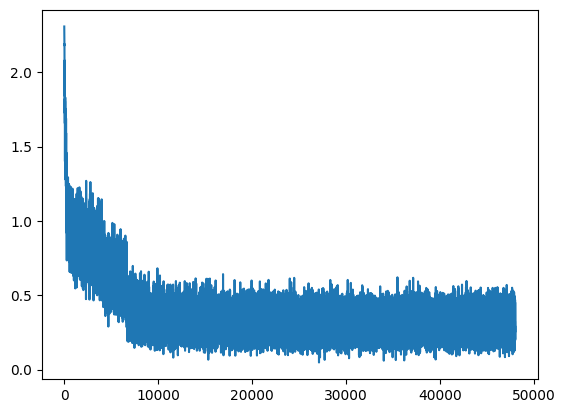

In [ ]:
plt.plot(train_loss_hist_sgd)

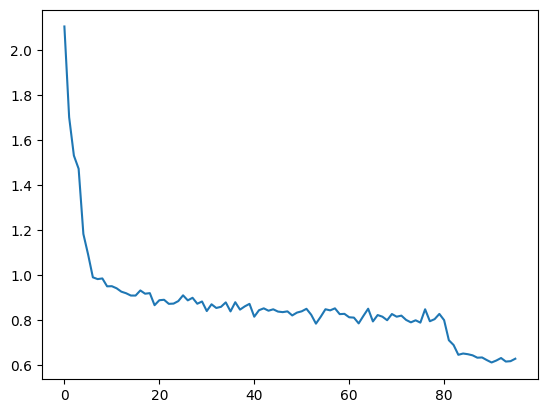

In [ ]:
chunk_size = 50
train_loss_mean = [np.array(train_loss_hist)[i:i + chunk_size].mean() for i in range(0, len(train_loss_hist), chunk_size)]
plt.plot(train_loss_mean)

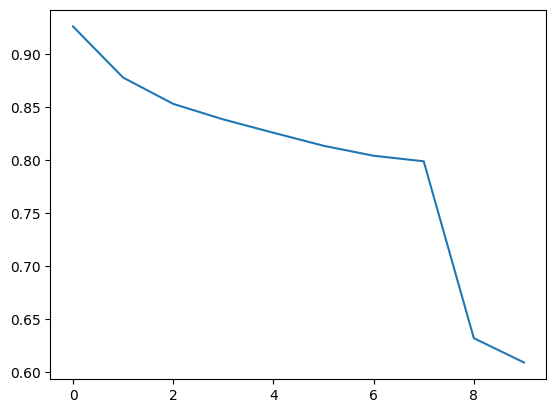

In [ ]:
plt.plot(val_loss_hist)

## Adam

In [ ]:
def train_without_early_stop_minibatch(config, X_train, yoh_train, X_val, yoh_val, num_epochs=10, lr=1e-1, weight_decay=1e-3, show_freq=1, batch_size=100):
    torch.manual_seed(100)
    model = PTDeep(configs[1], device=X_train.device.type)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loss_hist = []
    val_loss_hist = []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(num_epochs):
        shuffle_idx = torch.randperm(X_train.shape[0])
        X_train_shuffled = X_train[shuffle_idx]
        yoh_train_shuffled = yoh_train[shuffle_idx]
        for j in range(0, X_train.shape[0], batch_size):
            X_train_mb = X_train_shuffled[j:j+batch_size]
            yoh_train_mb = yoh_train_shuffled[j:j+batch_size]
            optimizer.zero_grad()
            loss = model.get_loss(X_train_mb, yoh_train_mb)
            loss.backward()
            optimizer.step()
            train_loss_hist.append(loss.item())

        with torch.no_grad():
            val_loss = model.get_loss(X_val, yoh_val)
            val_loss_hist.append(val_loss.item())
        if i % show_freq == 0:
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = deepcopy(model)
            print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}")

    return best_model, train_loss_hist, val_loss_hist

In [ ]:
model, train_loss_hist_adam, val_loss_hist_adam = train_without_early_stop_minibatch(configs[1], X_train, yoh_train, X_val, yoh_val, num_epochs=100, lr=1e-4)

Step: 0/100, Train Loss: 1.02, Val Loss: 1.00
Step: 1/100, Train Loss: 0.95, Val Loss: 0.81
Step: 2/100, Train Loss: 0.71, Val Loss: 0.75
Step: 3/100, Train Loss: 0.88, Val Loss: 0.72
Step: 4/100, Train Loss: 0.69, Val Loss: 0.70
Step: 5/100, Train Loss: 0.52, Val Loss: 0.69
Step: 6/100, Train Loss: 0.61, Val Loss: 0.68
Step: 7/100, Train Loss: 0.69, Val Loss: 0.67
Step: 8/100, Train Loss: 0.91, Val Loss: 0.66
Step: 9/100, Train Loss: 0.77, Val Loss: 0.65
Step: 10/100, Train Loss: 0.74, Val Loss: 0.65
Step: 11/100, Train Loss: 0.55, Val Loss: 0.64
Step: 12/100, Train Loss: 0.59, Val Loss: 0.64
Step: 13/100, Train Loss: 0.73, Val Loss: 0.63
Step: 14/100, Train Loss: 0.62, Val Loss: 0.63
Step: 15/100, Train Loss: 0.78, Val Loss: 0.63
Step: 16/100, Train Loss: 0.66, Val Loss: 0.62
Step: 17/100, Train Loss: 0.48, Val Loss: 0.62
Step: 18/100, Train Loss: 0.62, Val Loss: 0.62
Step: 19/100, Train Loss: 0.66, Val Loss: 0.61
Step: 20/100, Train Loss: 0.65, Val Loss: 0.61
Step: 21/100, Train Los

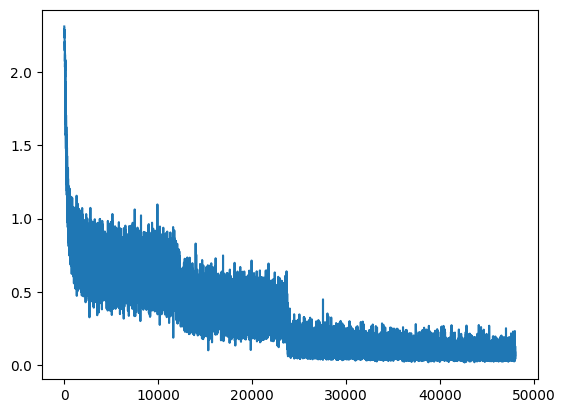

In [ ]:
plt.plot(train_loss_hist_adam)

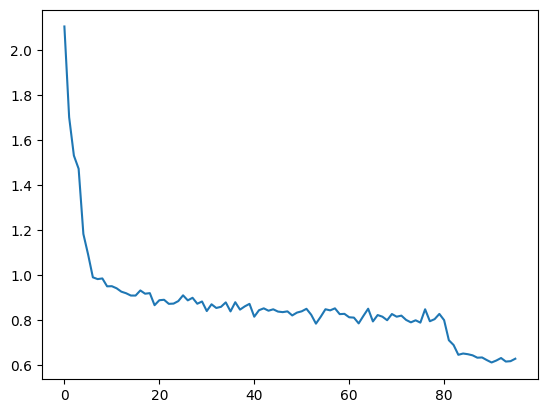

In [ ]:
chunk_size = 50
train_loss_mean = [np.array(train_loss_hist)[i:i + chunk_size].mean() for i in range(0, len(train_loss_hist), chunk_size)]
plt.plot(train_loss_mean)

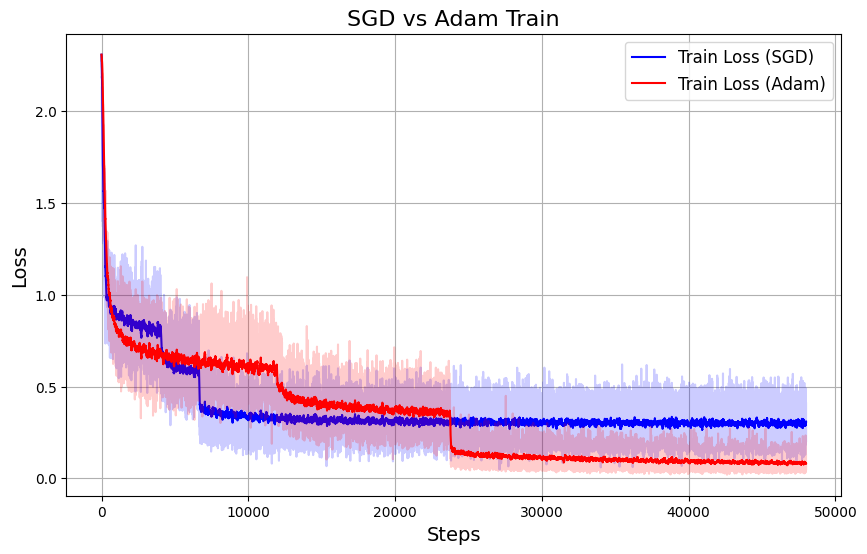

In [ ]:
def moving_average_with_warmup(data, window_size=50):
    moving_avg = []
    for i in range(len(data)):
        current_window = data[max(0, i - window_size + 1):i + 1]
        moving_avg.append(sum(current_window) / len(current_window))
    return moving_avg

sgd_loss_hist_smooth = moving_average_with_warmup(train_loss_hist_sgd)
adam_loss_hist_smooth = moving_average_with_warmup(train_loss_hist_adam)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_hist_sgd, color="blue", alpha=0.2)
plt.plot(sgd_loss_hist_smooth, color="blue", label="Train Loss (SGD)")

plt.plot(train_loss_hist_adam, color="red", alpha=0.2)
plt.plot(adam_loss_hist_smooth, color="red", label="Train Loss (Adam)")

plt.legend(fontsize=12)
plt.title("SGD vs Adam Train", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.show()

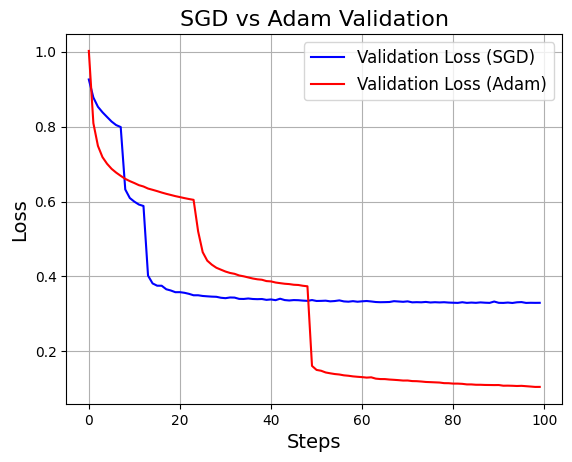

In [ ]:
plt.plot(val_loss_hist_sgd, label="Validation Loss (SGD)", color="blue")
plt.plot(val_loss_hist_adam, label="Validation Loss (Adam)", color="red")
plt.legend(fontsize=12)
plt.title("SGD vs Adam Validation", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
_, accuracy, recall, precision = evaluate(model, X_train, y_train)
print("Train set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_val, y_val)
print("Validation set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_test, y_test)
print("Test set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Train set
=> Accuracy: 0.98, Recall: [0.99259886 0.98903108 0.98404032 0.9588873  0.98625134 0.97687327
 0.99052233 0.98128019 0.97657425 0.97501041], Precision: [0.98987769 0.98310013 0.97503121 0.97972832 0.98245239 0.98392732
 0.98698846 0.98108271 0.97135528 0.97826995]
Validation set
=> Accuracy: 0.97, Recall: [0.98576214 0.98977987 0.97324415 0.95491143 0.97725358 0.94712853
 0.98717949 0.97532768 0.96327212 0.95989538], Precision: [0.98411371 0.97824398 0.97080901 0.96110211 0.97890295 0.97284644
 0.97715736 0.98214286 0.95608948 0.95407279]
Test set
=> Accuracy: 0.97, Recall: [0.98979592 0.99118943 0.97577519 0.96534653 0.97352342 0.96188341
 0.97599165 0.96498054 0.96303901 0.95837463], Precision: [0.97585513 0.97996516 0.96920115 0.96343874 0.9745158  0.975
 0.97497393 0.96969697 0.96701031 0.97283702]


In [ ]:
probs = model.forward(X_test)
losses = torch.sum(-yoh_test * torch.log(probs + 1e-12), dim=1)
sorted_losses, sorted_indices = torch.sort(losses)

lowest_loss_indices = sorted_indices[:10]
lowest_loss_values = sorted_losses[:10]
highest_loss_indices = sorted_indices[-10:]
highest_loss_values = sorted_losses[-10:]

lowest_loss_samples = X_test[lowest_loss_indices]
highest_loss_samples = X_test[highest_loss_indices]
losses.mean().item()

0.15282407402992249

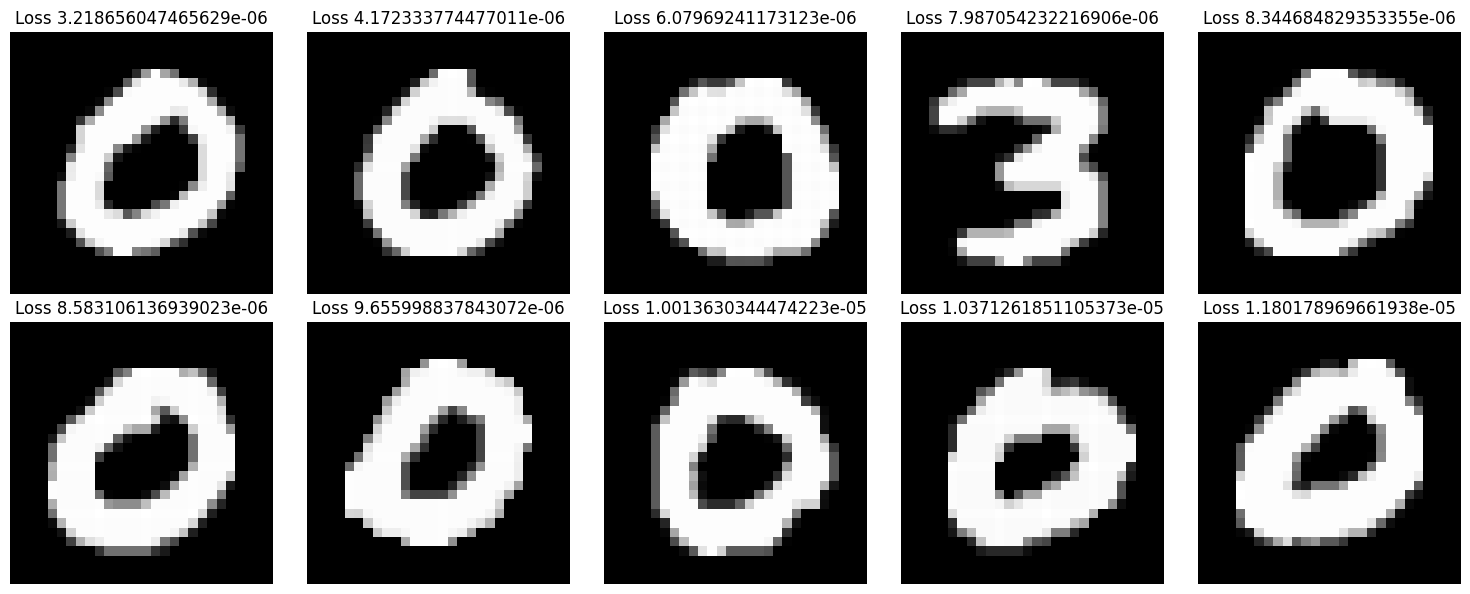

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    loss = lowest_loss_values[i].detach().cpu().item()
    sample = lowest_loss_samples[i].detach().cpu().numpy()
    axes[i].set_title(f"Loss {loss}")
    axes[i].imshow(sample, cmap="gray")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

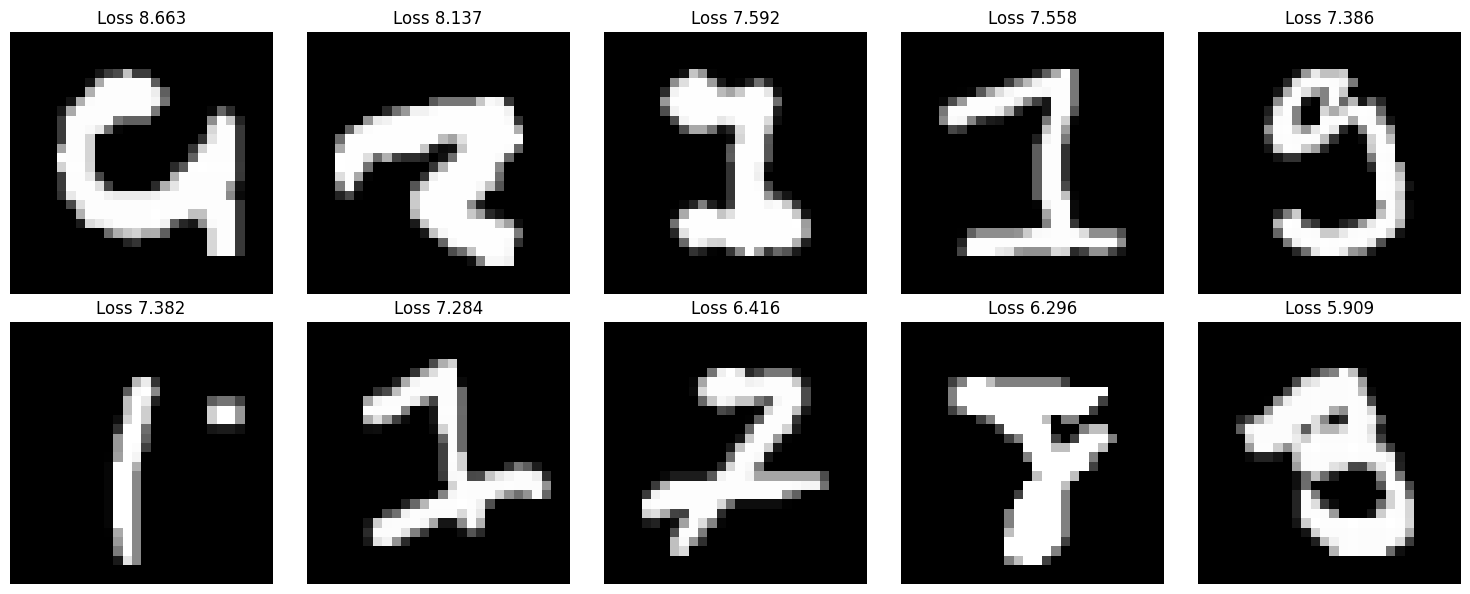

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    loss = highest_loss_values[i].detach().cpu().item()
    sample = highest_loss_samples[i].detach().cpu().numpy()
    axes[-i - 1].set_title(f"Loss {loss:.3f}")
    axes[-i - 1].imshow(sample, cmap="gray")
    axes[-i - 1].axis("off")

plt.tight_layout()
plt.show()

## Scheduler

In [ ]:
def train_without_early_stop_minibatch(config, X_train, yoh_train, X_val, yoh_val, num_epochs=10, lr=1e-4, weight_decay=1e-3, show_freq=1, batch_size=100):
    torch.manual_seed(100)
    model = PTDeep(configs[1], device=X_train.device.type)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-1e-4)
    train_loss_hist = []
    val_loss_hist = []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(num_epochs):
        shuffle_idx = torch.randperm(X_train.shape[0])
        X_train_shuffled = X_train[shuffle_idx]
        yoh_train_shuffled = yoh_train[shuffle_idx]
        for j in range(0, X_train.shape[0], batch_size):
            X_train_mb = X_train_shuffled[j:j+batch_size]
            yoh_train_mb = yoh_train_shuffled[j:j+batch_size]
            optimizer.zero_grad()
            loss = model.get_loss(X_train_mb, yoh_train_mb)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss_hist.append(loss.item())

        with torch.no_grad():
            val_loss = model.get_loss(X_val, yoh_val)
            val_loss_hist.append(val_loss.item())
        if i % show_freq == 0:
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = deepcopy(model)

            lr = optimizer.param_groups[0]["lr"]
            print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}, Learning rate: {lr}")

    return best_model, train_loss_hist, val_loss_hist

In [ ]:
model, train_loss_hist, val_loss_hist = train_without_early_stop_minibatch(configs[1], X_train, yoh_train, X_val, yoh_val, num_epochs=30)

Step: 0/30, Train Loss: 0.87, Val Loss: 0.89, Learning rate: 9.531314994066547e-05
Step: 1/30, Train Loss: 0.70, Val Loss: 0.67, Learning rate: 9.084596551611766e-05
Step: 2/30, Train Loss: 0.50, Val Loss: 0.60, Learning rate: 8.658815132742235e-05
Step: 3/30, Train Loss: 0.66, Val Loss: 0.57, Learning rate: 8.252989450555643e-05
Step: 4/30, Train Loss: 0.59, Val Loss: 0.55, Learning rate: 7.866184209595399e-05
Step: 5/30, Train Loss: 0.60, Val Loss: 0.53, Learning rate: 7.4975079503006e-05
Step: 6/30, Train Loss: 0.41, Val Loss: 0.52, Learning rate: 7.146110994483312e-05
Step: 7/30, Train Loss: 0.47, Val Loss: 0.51, Learning rate: 6.811183487098239e-05
Step: 8/30, Train Loss: 0.49, Val Loss: 0.50, Learning rate: 6.491953529791781e-05
Step: 9/30, Train Loss: 0.53, Val Loss: 0.50, Learning rate: 6.187685401928757e-05
Step: 10/30, Train Loss: 0.51, Val Loss: 0.49, Learning rate: 5.897677864997021e-05
Step: 11/30, Train Loss: 0.55, Val Loss: 0.48, Learning rate: 5.621262546482045e-05
Step

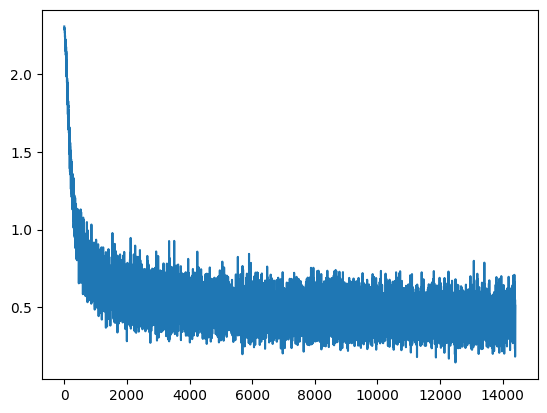

In [ ]:
plt.plot(train_loss_hist)

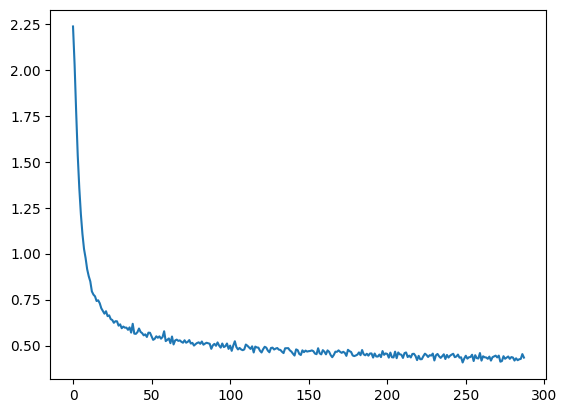

In [ ]:
chunk_size = 50
train_loss_mean = [np.array(train_loss_hist)[i:i + chunk_size].mean() for i in range(0, len(train_loss_hist), chunk_size)]
plt.plot(train_loss_mean)

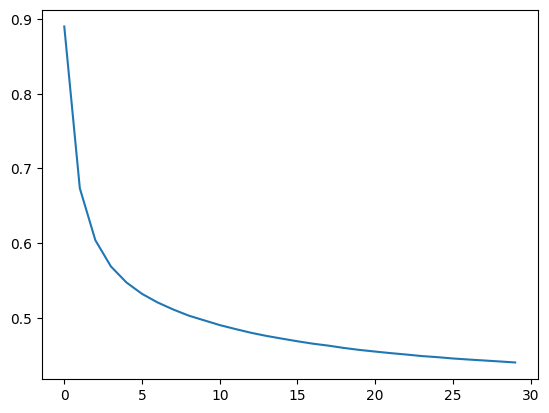

In [ ]:
plt.plot(val_loss_hist)

In [ ]:
_, accuracy, recall, precision = evaluate(model, X_train, y_train)
print("Train set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_val, y_val)
print("Validation set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_test, y_test)
print("Test set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Train set
=> Accuracy: 0.85, Recall: [0.97695073 0.97659963 0.94309114 0.9343424  0.95037594 0.92506938
 0.96777591 0.         0.92542446 0.93815077], Precision: [0.56576047 0.94716312 0.91503667 0.89903562 0.91765194 0.92506938
 0.95371523 0.         0.92324185 0.80763715]
Validation set
=> Accuracy: 0.85, Recall: [0.97738693 0.98506289 0.93812709 0.92753623 0.95619208 0.91522334
 0.97777778 0.         0.92821369 0.93461203], Precision: [0.55281857 0.94423512 0.91967213 0.87938931 0.92956593 0.92279412
 0.94701987 0.         0.9352397  0.80844646]
Test set
=> Accuracy: 0.85, Recall: [0.98571429 0.9814978  0.93992248 0.95049505 0.95519348 0.91255605
 0.96137787 0.         0.92402464 0.93359762], Precision: [0.56690141 0.96200345 0.91079812 0.88479263 0.91601562 0.93778802
 0.94364754 0.         0.92307692 0.82270742]


## Rand init

In [ ]:
from math import log
-log(1/10)

2.3025850929940455

In [ ]:
model = PTDeep(configs[1], device=X_train.device.type)
model.get_loss(X_test, yoh_test)

tensor(2.3069, device='cuda:0', grad_fn=<DivBackward0>)

## SVM

In [ ]:
X_train_flat_np = X_train.reshape(X_train.shape[0], -1).detach().cpu().numpy()
X_val_flat_np = X_val.reshape(X_val.shape[0], -1).detach().cpu().numpy()
X_test_flat_np = X_test.reshape(X_test.shape[0], -1).detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_val_np = y_val.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

In [ ]:
X_train_flat_np_mb = X_train_flat_np[:1000]
y_train_np_mb = y_train_np[:1000]

In [ ]:
from sklearn.svm import SVC

In [ ]:
linear_svc = SVC(random_state=100, kernel="linear")
#linear_svc.fit(X_train_flat_np_mb, y_train_np_mb)
linear_svc.fit(X_train_flat_np, y_train_np)

SVC(kernel='linear', random_state=100)

In [ ]:
kernel_svc = SVC(random_state=100, kernel="rbf")
#kernel_svc.fit(X_train_flat_np_mb, y_train_np_mb)
kernel_svc.fit(X_train_flat_np, y_train_np)

SVC(random_state=100)

In [ ]:
y_train_preds = linear_svc.predict(X_train_flat_np)
_, accuracy, recall, precision = eval_perf_multi(y_train_preds, y_train_np)
print("Train set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

y_val_preds = linear_svc.predict(X_val_flat_np)
_, accuracy, recall, precision = eval_perf_multi(y_val_preds, y_val_np)
print("Validation set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

y_test_preds = linear_svc.predict(X_test_flat_np)
_, accuracy, recall, precision = eval_perf_multi(y_test_preds, y_test_np)
print("Test set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Train set
=> Accuracy: 0.87, Recall: [0.95453584 0.9606947  0.88702226 0.8009818  0.87604726 0.82446809
 0.90859309 0.90096618 0.77627337 0.83277801], Precision: [0.94593462 0.92943049 0.84378746 0.85651794 0.88325753 0.77787475
 0.92396659 0.88144939 0.87669903 0.81132075]
Validation set
=> Accuracy: 0.88, Recall: [0.95477387 0.97169811 0.88963211 0.80032206 0.88037068 0.82771194
 0.91965812 0.91364688 0.80884808 0.83435048], Precision: [0.9484193  0.92653673 0.85461847 0.87809187 0.9047619  0.77806341
 0.93079585 0.88830585 0.88817599 0.80827703]
Test set
=> Accuracy: 0.88, Recall: [0.96734694 0.969163   0.89534884 0.77722772 0.87576375 0.83071749
 0.90814196 0.88424125 0.7926078  0.84142716], Precision: [0.94894895 0.94017094 0.86516854 0.86932447 0.87487284 0.76234568
 0.92750533 0.88510224 0.87231638 0.80473934]


In [ ]:
y_train_preds = kernel_svc.predict(X_train_flat_np)
_, accuracy, recall, precision = eval_perf_multi(y_train_preds, y_train_np)
print("Train set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

y_val_preds = kernel_svc.predict(X_val_flat_np)
_, accuracy, recall, precision = eval_perf_multi(y_val_preds, y_val_np)
print("Validation set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

y_test_preds = kernel_svc.predict(X_test_flat_np)
_, accuracy, recall, precision = eval_perf_multi(y_test_preds, y_test_np)
print("Test set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Train set
=> Accuracy: 0.91, Recall: [0.9678579  0.9725777  0.90844183 0.81611782 0.91535983 0.90471785
 0.92333614 0.92391304 0.83021706 0.87838401], Precision: [0.94958506 0.95067906 0.88774882 0.93246086 0.88384153 0.82514238
 0.94789189 0.91234347 0.9091551  0.84954683]
Validation set
=> Accuracy: 0.91, Recall: [0.97236181 0.97484277 0.90551839 0.82447665 0.90901432 0.90519599
 0.94017094 0.94140324 0.85559265 0.88055798], Precision: [0.95320197 0.94873757 0.89430223 0.93772894 0.90596138 0.82957393
 0.96322242 0.91392216 0.91354724 0.85304054]
Test set
=> Accuracy: 0.91, Recall: [0.9744898  0.98061674 0.90697674 0.82772277 0.91242363 0.9058296
 0.91336117 0.91634241 0.85010267 0.88602577], Precision: [0.93627451 0.96782609 0.9        0.94570136 0.87329435 0.82030457
 0.93783494 0.91634241 0.9159292  0.86796117]


## BatchNorm

In [ ]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, device="cpu"):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features, device=device) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features, device=device))

    def forward(self, x):
        return x @ self.weight.T + self.bias

class BatchNorm(nn.Module):
    def __init__(self, device="cpu", eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.device = device
        self.momentum = momentum

        self.gamma = nn.Parameter(torch.ones(1, device=device))
        self.beta = nn.Parameter(torch.zeros(1, device=device))

        self.register_buffer("running_mean", torch.zeros(1, device=device))
        self.register_buffer("running_var", torch.ones(1, device=device))

    def forward(self, x):
        if x.dim() != 2:
            raise ValueError(f"expected shape 2D input, got {x.dim()}D input")

        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            variance = x.var(dim=0, unbiased=False, keepdim=True)
            x_normalized = (x - mean) / torch.sqrt(variance + self.eps)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.detach()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance.detach()
        else:
            x_normalized = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        x_normalized = self.gamma * x_normalized + self.beta
        return x_normalized

In [ ]:
class PTDeepBN(nn.Module):
    def __init__(self, layers, activation=nn.ReLU, device="cpu"):
        super().__init__()
        self.activation = activation()
        self.flat = nn.Flatten()
        self.layers = nn.Sequential()

        if device == "cuda" and torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        for i, (dim_in, dim_out) in enumerate(zip(layers, layers[1:])):
            self.layers.append(Linear(dim_in, dim_out, device=self.device))
            if i != len(layers) - 2:
                self.layers.append(BatchNorm(device=self.device))
                self.layers.append(activation())

        self.layers.append(nn.Softmax(dim=1))

    def forward(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X = self.flat(X)
        X = self.layers(X)
        return X

    def get_loss(self, X, Yoh_):
        probs = self.forward(X)
        loss = -torch.sum(Yoh_ * torch.log(probs + 1e-12)) / X.shape[0]
        return loss

    def count_params(self):
        total = 0
        for name, param in self.named_parameters():
            print(f"{name} ... {list(param.shape)}, numel={param.numel()}")
            total += param.numel()
        return total

    @torch.no_grad()
    def predict(self, X):
        probs = self.forward(X)
        preds = probs.argmax(axis=1)
        return preds

def evaluate(model, X, Y_):
    Y = model.predict(X)
    M, accuracy, recall, precision = eval_perf_multi(Y.cpu().numpy(), Y_.cpu().numpy())
    return M, accuracy, recall, precision

def visualize_weights(w, filename=None):
    w = w.reshape(C, 28, 28)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(10):
        axes[i].set_title(f"Weights for digit {i}")
        axes[i].imshow(w[i], cmap="gray")
        axes[i].axis("off")

    if filename is not None:
        plt.savefig(os.path.join(IMG_DIR, filename), dpi=300)

    plt.tight_layout()
    plt.show()

In [ ]:
X_train.shape

torch.Size([48000, 28, 28])

In [ ]:
num_epochs=10; lr=1e-1; weight_decay=1e-3; show_freq=1; batch_size=48000
torch.manual_seed(100)
model = PTDeepBN([784, 100, 10], device=X_train.device.type)
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
train_loss_hist = []
val_loss_hist = []
best_model = deepcopy(model)
best_loss = float("inf")

for i in range(num_epochs):
    model.train()
    shuffle_idx = torch.randperm(X_train.shape[0])
    X_train_shuffled = X_train[shuffle_idx]
    yoh_train_shuffled = yoh_train[shuffle_idx]
    for j in range(0, X_train.shape[0], batch_size):
        X_train_mb = X_train_shuffled[j:j+batch_size]
        yoh_train_mb = yoh_train_shuffled[j:j+batch_size]
        optimizer.zero_grad()
        loss = model.get_loss(X_train_mb, yoh_train_mb)
        loss.backward()
        optimizer.step()
        train_loss_hist.append(loss.item())

    for layer in model.layers:
        if isinstance(layer, Linear):
            #print(layer.bias.mean().item())
            pass
    with torch.no_grad():
        model.eval()
        val_loss = model.get_loss(X_val, yoh_val)
        val_loss_hist.append(val_loss.item())
    if i % show_freq == 0:
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = deepcopy(model)

        print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}")

Step: 0/10, Train Loss: 2.30, Val Loss: 2.00
Step: 1/10, Train Loss: 2.19, Val Loss: 1.82
Step: 2/10, Train Loss: 2.08, Val Loss: 1.64
Step: 3/10, Train Loss: 1.95, Val Loss: 1.46
Step: 4/10, Train Loss: 1.80, Val Loss: 1.28
Step: 5/10, Train Loss: 1.63, Val Loss: 1.11
Step: 6/10, Train Loss: 1.45, Val Loss: 0.97
Step: 7/10, Train Loss: 1.29, Val Loss: 0.86
Step: 8/10, Train Loss: 1.14, Val Loss: 0.76
Step: 9/10, Train Loss: 1.01, Val Loss: 0.69


In [ ]:
evaluate(model, X_train, y_train)

(array([[4721,    1,    0,    0,    0,    0,    2,    0,    3,    2],
        [   0, 5456,    1,    1,    2,    0,    0,    5,    3,    2],
        [   1,    6, 4747,    1,    1,    0,    0,    2,    4,    0],
        [   1,    0,    5, 4870,    1,    4,    0,    1,    6,    1],
        [   0,    1,    0,    0, 4644,    0,    1,    1,    2,    6],
        [   1,    1,    2,    2,    2, 4301,    2,    1,   12,    0],
        [   5,    1,    2,    0,    1,    3, 4732,    0,    4,    0],
        [   1,    6,    3,    3,    5,    3,    0, 4937,    1,    9],
        [   1,    7,    4,    9,    1,    0,    1,    0, 4624,    6],
        [   1,    2,    2,    2,    5,    5,    0,   12,    5, 4768]],
       dtype=int32),
 0.9958333333333333,
 array([0.99830831, 0.99744059, 0.99685006, 0.99611372, 0.99763695,
        0.99468085, 0.99663016, 0.99376006, 0.99376746, 0.99291962]),
 array([0.9976754 , 0.99543879, 0.99601343, 0.99631751, 0.996139  ,
        0.99652456, 0.99873364, 0.99556362, 0.99142

In [ ]:
_, accuracy, recall, precision = evaluate(model, X_train, y_train)
print("Train set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_val, y_val)
print("Validation set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

_, accuracy, recall, precision = evaluate(model, X_test, y_test)
print("Test set")
print(f"=> Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

Train set
=> Accuracy: 1.00, Recall: [0.99830831 0.99744059 0.99685006 0.99611372 0.99763695 0.99468085
 0.99663016 0.99376006 0.99376746 0.99291962], Precision: [0.9976754  0.99543879 0.99601343 0.99631751 0.996139   0.99652456
 0.99873364 0.99556362 0.99142367 0.99457655]
Validation set
=> Accuracy: 0.98, Recall: [0.98659966 0.99449686 0.97240803 0.97504026 0.9789385  0.95715588
 0.98632479 0.97918273 0.96911519 0.95553618], Precision: [0.98659966 0.98062016 0.97567114 0.96340493 0.97729184 0.96863469
 0.98716852 0.97918273 0.9675     0.97163121]
Test set
=> Accuracy: 0.97, Recall: [0.99081633 0.9938326  0.97189922 0.98712871 0.97759674 0.96188341
 0.96659708 0.97568093 0.96201232 0.95341923], Precision: [0.971      0.98601399 0.97949219 0.95773295 0.96774194 0.97945205
 0.98720682 0.9728419  0.96797521 0.97565923]


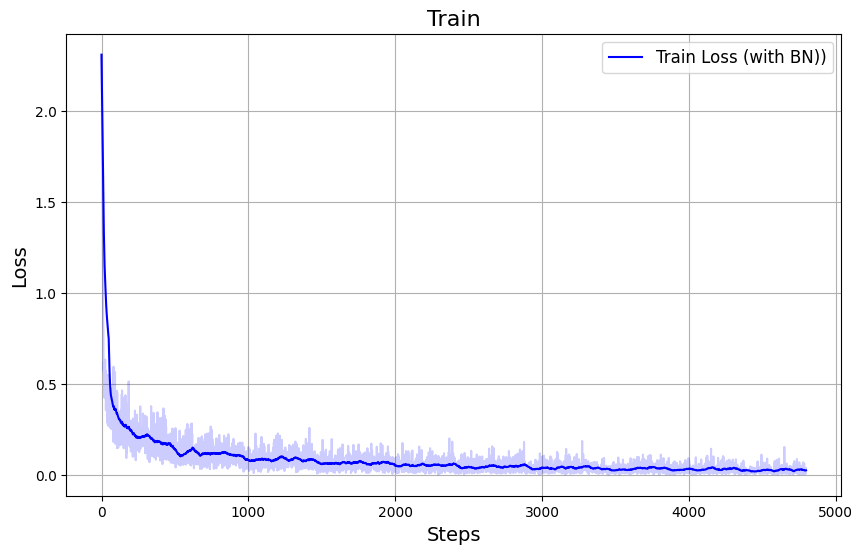

In [ ]:
def moving_average_with_warmup(data, window_size=50):
    moving_avg = []
    for i in range(len(data)):
        current_window = data[max(0, i - window_size + 1):i + 1]
        moving_avg.append(sum(current_window) / len(current_window))
    return moving_avg

bn_loss_hist_smooth = moving_average_with_warmup(train_loss_hist)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_hist, color="blue", alpha=0.2)
plt.plot(bn_loss_hist_smooth, color="blue", label="Train Loss (with BN))")

plt.legend(fontsize=12)
plt.title("Train", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy

class Linear(nn.Module):
    def __init__(self, in_features, out_features, device="cpu"):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features, device=device) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features, device=device))

    def forward(self, x):
        return x @ self.weight.T + self.bias

class BatchNorm(nn.Module):
    def __init__(self, device="cpu", eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.device = device
        self.momentum = momentum

        self.gamma = nn.Parameter(torch.ones(1, device=device))
        self.beta = nn.Parameter(torch.zeros(1, device=device))

        self.register_buffer("running_mean", torch.zeros(1, device=device))
        self.register_buffer("running_var", torch.ones(1, device=device))

    def forward(self, x):
        if x.dim() != 2:
            raise ValueError(f"expected shape 2D input, got {x.dim()}D input")

        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            variance = x.var(dim=0, unbiased=False, keepdim=True)
            x_normalized = (x - mean) / torch.sqrt(variance + self.eps)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean.detach()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance.detach()
        else:
            x_normalized = (x - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        x_normalized = self.gamma * x_normalized + self.beta
        return x_normalized

class Network(nn.Module):
    def __init__(self, layers, activation=nn.ReLU, BN=True, device="cpu"):
        super().__init__()
        self.activation = activation()
        self.flat = nn.Flatten()
        self.layers = nn.Sequential()

        if device == "cuda" and torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        for i, (dim_in, dim_out) in enumerate(zip(layers, layers[1:])):
            self.layers.append(Linear(dim_in, dim_out, device=self.device))
            if i != len(layers) - 2:
                if BN:
                    self.layers.append(BatchNorm(device=self.device))
                self.layers.append(activation())

        self.layers.append(nn.Softmax(dim=1))

    def forward(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X = self.flat(X)
        X = self.layers(X)
        return X

    def get_loss(self, X, Yoh_):
        probs = self.forward(X)
        loss = -torch.sum(Yoh_ * torch.log(probs + 1e-12)) / X.shape[0]
        return loss

    def count_params(self):
        total = 0
        for name, param in self.named_parameters():
            print(f"{name} ... {list(param.shape)}, numel={param.numel()}")
            total += param.numel()
        return total

    @torch.no_grad()
    def predict(self, X):
        probs = self.forward(X)
        preds = probs.argmax(axis=1)
        return preds

def evaluate(model, X, Y_):
    Y = model.predict(X)
    M, accuracy, recall, precision = eval_perf_multi(Y.cpu().numpy(), Y_.cpu().numpy())
    return M, accuracy, recall, precision

def train(model, X_train, yoh_train, X_val, yoh_val, optimizer=optim.SGD, scheduler=False, num_epochs=10, lr=1e-4, weight_decay=1e-3, show_freq=1, batch_size=100, lr_decay=1-1e-4, seed=100):
    torch.manual_seed(seed)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    if scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

    if batch_size == -1 or batch_size >= X_train.shape[0] or batch_size == None:
        batch_size = X_train.shape[0]

    train_loss_history, val_loss_history = [], []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(num_epochs):
        model.train()
        shuffle_idx = torch.randperm(X_train.shape[0])
        X_train_shuffled = X_train[shuffle_idx]
        yoh_train_shuffled = yoh_train[shuffle_idx]

        for j in range(0, X_train.shape[0], batch_size):
            X_train_batch = X_train_shuffled[j:j+batch_size]
            yoh_train_batch = yoh_train_shuffled[j:j+batch_size]

            optimizer.zero_grad()
            loss = model.get_loss(X_train_batch, yoh_train_batch)
            loss.backward()

            optimizer.step()
            if scheduler:
                scheduler.step()
            train_loss_history.append(loss.item())

        with torch.no_grad():
            model.eval()
            val_loss = model.get_loss(X_val, yoh_val)
            val_loss_history.append(val_loss.item())

        if i % show_freq == 0:
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = deepcopy(model)

            print(f"Step: {i}/{num_epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}")

    return best_model, train_loss_history, val_loss_history

In [ ]:
model_bn = Network([784, 100, 10], device=X_train.device.type)
model_bn, train_loss_history_bn, val_loss_history_bn = train(model_bn, X_train, yoh_train, X_val, yoh_val, optimizer=optim.SGD, scheduler=True, num_epochs=10, lr=1e-1, weight_decay=1e-3, show_freq=1, batch_size=100)

Step: 0/10, Train Loss: 0.20, Val Loss: 0.14
Step: 1/10, Train Loss: 0.05, Val Loss: 0.10
Step: 2/10, Train Loss: 0.03, Val Loss: 0.09
Step: 3/10, Train Loss: 0.17, Val Loss: 0.10
Step: 4/10, Train Loss: 0.05, Val Loss: 0.09
Step: 5/10, Train Loss: 0.03, Val Loss: 0.08
Step: 6/10, Train Loss: 0.06, Val Loss: 0.08
Step: 7/10, Train Loss: 0.05, Val Loss: 0.08
Step: 8/10, Train Loss: 0.05, Val Loss: 0.08
Step: 9/10, Train Loss: 0.04, Val Loss: 0.08


In [ ]:
model_nobn = Network([784, 100, 10], BN=False, device=X_train.device.type)
model_nobn, train_loss_history_nobn, val_loss_history_nobn = train(model_nobn, X_train, yoh_train, X_val, yoh_val, optimizer=optim.Adam, scheduler=True, num_epochs=10, lr=1e-4, weight_decay=1e-3, show_freq=1, batch_size=100)

Step: 0/10, Train Loss: 0.22, Val Loss: 0.19
Step: 1/10, Train Loss: 0.08, Val Loss: 0.15
Step: 2/10, Train Loss: 0.04, Val Loss: 0.12
Step: 3/10, Train Loss: 0.24, Val Loss: 0.11
Step: 4/10, Train Loss: 0.05, Val Loss: 0.10
Step: 5/10, Train Loss: 0.07, Val Loss: 0.10
Step: 6/10, Train Loss: 0.06, Val Loss: 0.10
Step: 7/10, Train Loss: 0.04, Val Loss: 0.09
Step: 8/10, Train Loss: 0.03, Val Loss: 0.09
Step: 9/10, Train Loss: 0.06, Val Loss: 0.09


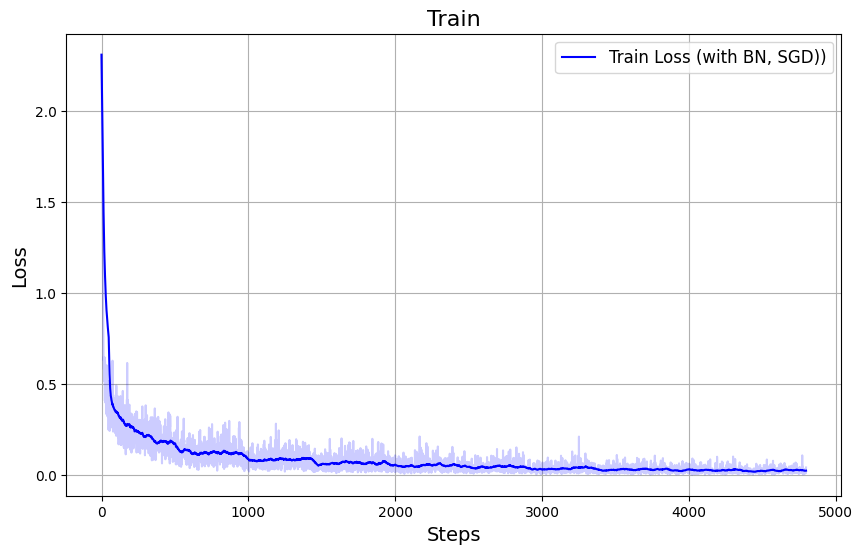

In [ ]:
def moving_average_with_warmup(data, window_size=50):
    moving_avg = []
    for i in range(len(data)):
        current_window = data[max(0, i - window_size + 1):i + 1]
        moving_avg.append(sum(current_window) / len(current_window))
    return moving_avg

train_loss_history_bn_smooth = moving_average_with_warmup(train_loss_history_bn)
# train_loss_history_nobn_smooth = moving_average_with_warmup(train_loss_history_nobn)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_bn, color="blue", alpha=0.2)
plt.plot(train_loss_history_bn_smooth, color="blue", label="Train Loss (with BN, SGD))")

# plt.plot(train_loss_history_nobn, color="red", alpha=0.2)
# plt.plot(train_loss_history_nobn_smooth, color="red", label="Train Loss (without BN, Adam))")

plt.legend(fontsize=12)
plt.title("Train", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.show()

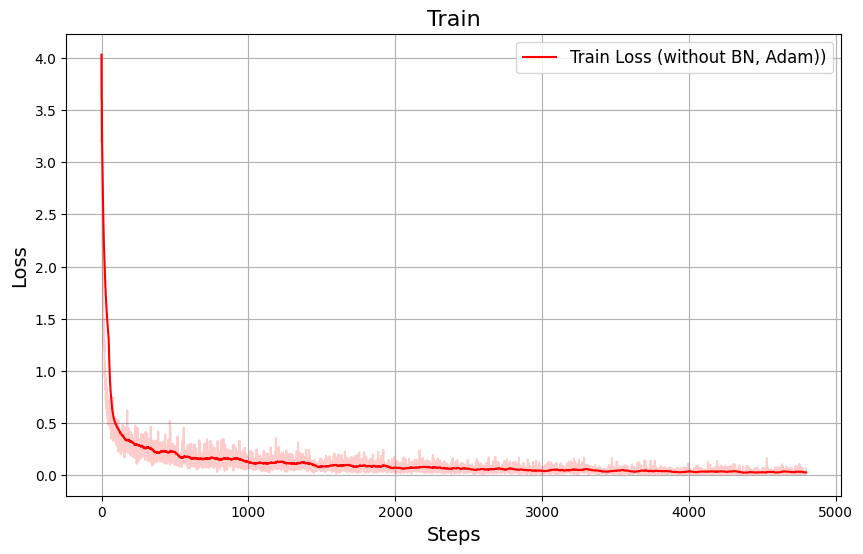

In [ ]:
def moving_average_with_warmup(data, window_size=50):
    moving_avg = []
    for i in range(len(data)):
        current_window = data[max(0, i - window_size + 1):i + 1]
        moving_avg.append(sum(current_window) / len(current_window))
    return moving_avg

# train_loss_history_bn_smooth = moving_average_with_warmup(train_loss_history_bn)
train_loss_history_nobn_smooth = moving_average_with_warmup(train_loss_history_nobn)

plt.figure(figsize=(10, 6))
# plt.plot(train_loss_history_bn, color="blue", alpha=0.2)
# plt.plot(train_loss_history_bn_smooth, color="blue", label="Train Loss (with BN, SGD))")

plt.plot(train_loss_history_nobn, color="red", alpha=0.2)
plt.plot(train_loss_history_nobn_smooth, color="red", label="Train Loss (without BN, Adam))")

plt.legend(fontsize=12)
plt.title("Train", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.show()

In [ ]:
model = Network([784, 200, 10], device=X_train.device.type)
model, train_loss_history, val_loss_history = train(model, X_train, yoh_train, X_val, yoh_val, optimizer=optim.Adam, scheduler=True, num_epochs=10, lr=1e-2, weight_decay=1e-3, show_freq=1, batch_size=100, lr_decay=1-1e-3)

Step: 0/10, Train Loss: 0.16, Val Loss: 0.15
Step: 1/10, Train Loss: 0.06, Val Loss: 0.13
Step: 2/10, Train Loss: 0.03, Val Loss: 0.11
Step: 3/10, Train Loss: 0.21, Val Loss: 0.09
Step: 4/10, Train Loss: 0.03, Val Loss: 0.08
Step: 5/10, Train Loss: 0.03, Val Loss: 0.07
Step: 6/10, Train Loss: 0.03, Val Loss: 0.07
Step: 7/10, Train Loss: 0.01, Val Loss: 0.07
Step: 8/10, Train Loss: 0.01, Val Loss: 0.06
Step: 9/10, Train Loss: 0.01, Val Loss: 0.06


In [ ]:
train_loss_history

[2.319106101989746,
 1.9446325302124023,
 1.6628069877624512,
 1.2916970252990723,
 0.989840030670166,
 0.9095292687416077,
 0.7444689273834229,
 0.6512090563774109,
 0.5879011154174805,
 0.6268470883369446,
 0.5289903283119202,
 0.4619186520576477,
 0.47119763493537903,
 0.40655410289764404,
 0.36006462574005127,
 0.4623660147190094,
 0.3644575774669647,
 0.43506258726119995,
 0.22989122569561005,
 0.42952874302864075,
 0.4146718680858612,
 0.5856672525405884,
 0.298092246055603,
 0.21550056338310242,
 0.5259387493133545,
 0.29547783732414246,
 0.3618558645248413,
 0.3715214431285858,
 0.3784131705760956,
 0.4288455545902252,
 0.3718642294406891,
 0.40333321690559387,
 0.6062982678413391,
 0.2139464169740677,
 0.3691943883895874,
 0.5480806827545166,
 0.3589986562728882,
 0.3950369954109192,
 0.31924983859062195,
 0.3109287619590759,
 0.3091825246810913,
 0.1996014416217804,
 0.3547406494617462,
 0.34644588828086853,
 0.3120829463005066,
 0.2943134009838104,
 0.3490739166736603,
 0.30

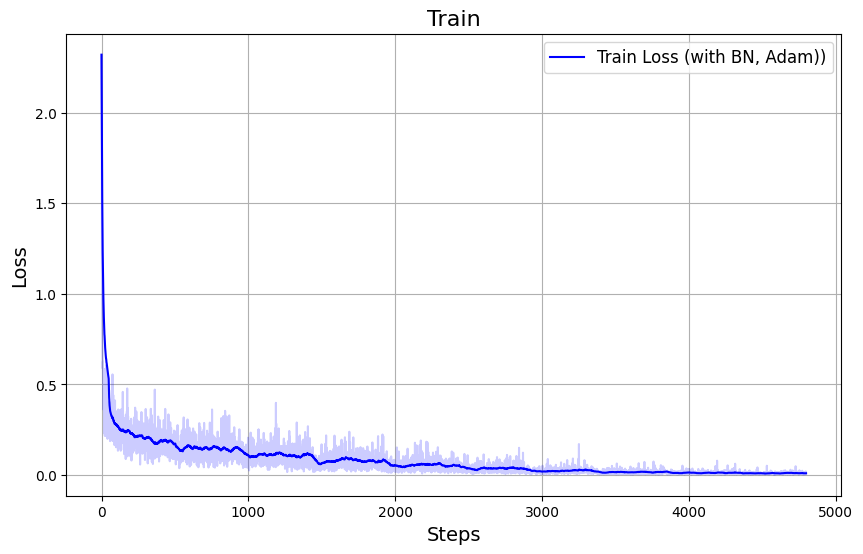

In [ ]:
def moving_average_with_warmup(data, window_size=50):
    moving_avg = []
    for i in range(len(data)):
        current_window = data[max(0, i - window_size + 1):i + 1]
        moving_avg.append(sum(current_window) / len(current_window))
    return moving_avg

train_loss_history_smooth = moving_average_with_warmup(train_loss_history)
# train_loss_history_nobn_smooth = moving_average_with_warmup(train_loss_history_nobn)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, color="blue", alpha=0.2)
plt.plot(train_loss_history_smooth, color="blue", label="Train Loss (with BN, Adam))")

# plt.plot(train_loss_history_nobn, color="red", alpha=0.2)
# plt.plot(train_loss_history_nobn_smooth, color="red", label="Train Loss (without BN, Adam))")

plt.legend(fontsize=12)
plt.title("Train", fontsize=16)
plt.xlabel("Steps", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True)

plt.show()